In [26]:
import numpy as np
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr

from eff.analysis import surprisal
from eff.util.util import load_results

np.random.seed(0)

In [17]:
base_path = Path("./out/nelex_unique")

In [18]:
langs_per_family = pd.read_csv("../northeuralex_vowel_harmony.csv")

lang_ids = list(langs_per_family['ID'])

lang2family = {}
for i, row in langs_per_family.iterrows():
    lang2family[row.ID] = row.Family


color_mapping = {
    "Abkhaz-Adyge": 'grey', "Tungusic": 'burlywood', "Mongolic": 'plum', 'Yukaghir': 'mediumseagreen', "Ainu": 'grey',
    "Dravidian": 'yellowgreen', "Burushaski": 'grey', "Nakh-Daghestanian": 'indianred', "Koreanic": 'grey', 
    "Eskimo-Aleut": 'cyan', "Chukotko-Kamchatkan": 'slateblue', "Yeniseian": 'grey', "Indo-European": 'goldenrod',
    "Sino-Tibetan": 'grey', "Nivkh": 'grey', "Uralic": 'forestgreen', "Turkic": 'darkcyan', "Japonic": 'grey',
    "Basque": 'grey', "Afro-Asiatic": 'olive', "Kartvelian": 'grey'
}


vh_langs = ['fin', 'tur', 'mnc', 'hun', 'khk']
non_vh_langs = ['arb', 'ain', 'ekk', 'hye', 'eus']

# sort alphabetically
color_mapping = dict(sorted(color_mapping.items(), key=lambda item: item[0]))

In [19]:
means_per_lang = dict(lang_ids=[], cons_only=[], vowel_only=[])

for lang_id in lang_ids:
    dataset, res, criterion, model = load_results(base_path, lang_id)

    # alphabet, bipa = dataset[lang_id]['clts'].output_alphabet, dataset[lang_id]['clts'].bipa
    surprisal_consonant_only = surprisal(
                        res['vowel_masking']['logprobs'],
                        res['vowel_masking']['targets'],
                        res['vowel_masking']['indices'],
                        ignore_vowel_index=999  
                        )
    surprisal_vowel_only = surprisal(
                            res['consonant_masking']['logprobs'],
                            res['consonant_masking']['targets'],
                            res['consonant_masking']['indices'],
                            ignore_vowel_index=0
                            )
    
    m_v = np.mean(surprisal_vowel_only)
    m_c = np.mean(surprisal_consonant_only)
    means_per_lang['lang_ids'].append(lang_id)
    means_per_lang['cons_only'].append(m_c)
    means_per_lang['vowel_only'].append(m_v)

(0.7845002312925531, 1.5988097485718414e-23)
Impact vowel-only -> consonant-only: 0.8256270175448815 Intercept: 0.34275852438743093


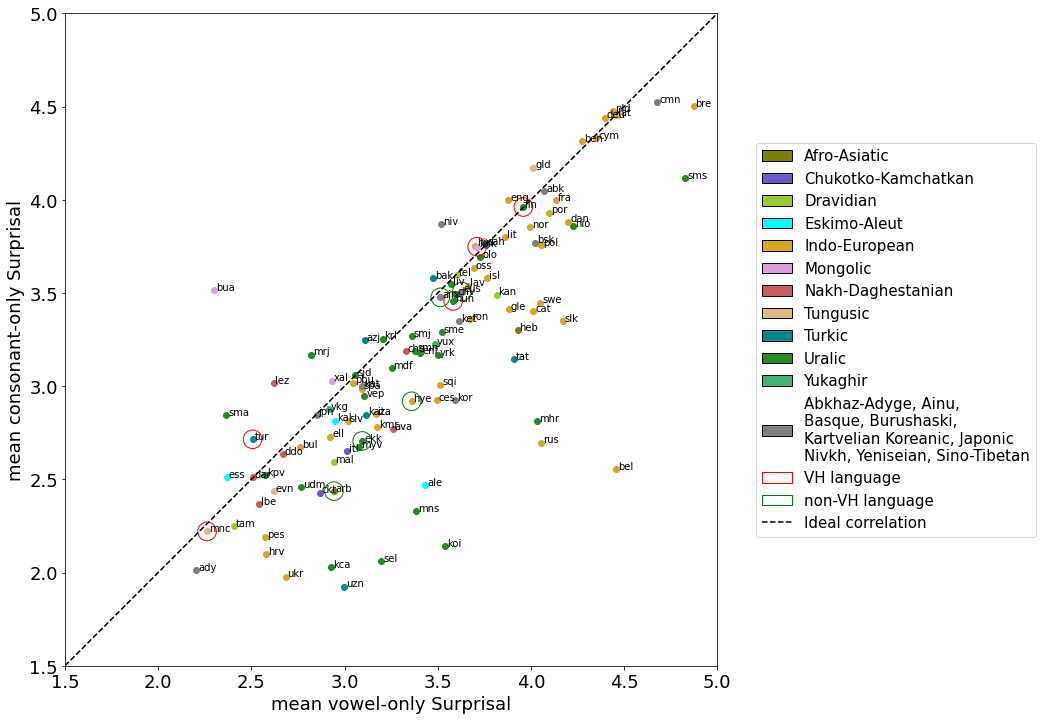

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))
singletons = [fam for fam, color in color_mapping.items() if color == 'grey']
singletons_str = "Abkhaz-Adyge, Ainu,\nBasque, Burushaski,\nKartvelian Koreanic, Japonic\nNivkh, Yeniseian, Sino-Tibetan"

legend_elements = []
for fam, color in color_mapping.items():
    if fam not in singletons:
        elem = Patch(facecolor=color, edgecolor='black', label=fam)
        legend_elements.append(elem)
legend_elements.append(Patch(facecolor='grey', edgecolor='black', \
    label=singletons_str))

plt.xlabel("mean vowel-only Surprisal", fontsize=18)
plt.ylabel("mean consonant-only Surprisal", fontsize=18)
plt.xlim(1.5, 5)
plt.ylim(1.5, 5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gca().set_aspect('equal', adjustable='box')

ax.plot(ax.get_xlim(), ax.get_ylim(), 4, ls="--", color='black')
ax.grid(True, which='both')

for i, lang_id in enumerate(means_per_lang['lang_ids']):
    x = means_per_lang['vowel_only'][i] # vowel-only
    y = means_per_lang['cons_only'][i] # consonant-only
    fam = lang2family[lang_id]
    plt.scatter(x, y, color=color_mapping[fam])
    plt.text(x=x+0.01, y=y, s=lang_id)
    if lang_id in vh_langs:
        circle = plt.Circle((x,y), 0.05, color='red', fill=False)
        ax.add_artist(circle)
    elif lang_id in non_vh_langs:
        circle = plt.Circle((x,y), 0.05, color='green', fill=False)
        ax.add_artist(circle)

red_circle = Circle((1,1), color='red', fill=False, label="VH language")
green_circle = Circle((1,1), color='green', fill=False, label="non-VH language")
ideal_line = Line2D([0,0],[0,1], color='black', label="Ideal correlation", linestyle='--')
# regression_line = Line2D([0,0],[0,1], color='black', label="Regression line", linestyle='--')
legend_elements.append(red_circle)
legend_elements.append(green_circle)
legend_elements.append(ideal_line)
# legend_elements.append(regression_line)

print(pearsonr(means_per_lang['cons_only'], means_per_lang['vowel_only']))

# print(means_per_lang['vowel_only']) 

# print(means_per_lang['cons_only'])

# coefs = np.polyfit(means_per_lang['cons_only'], means_per_lang['vowel_only'], 1)
coefs = np.polyfit(means_per_lang['vowel_only'], means_per_lang['cons_only'], 1)
print("Impact vowel-only -> consonant-only:", coefs[0], "Intercept:", coefs[1])

# poly1d_fn = np.poly1d(coefs)
# plt.plot(means_per_lang['vowel_only'], poly1d_fn(means_per_lang['vowel_only']), '--k')

plt.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize=15)
plt.savefig("../img/surprisal_VC_nelex_all.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()